In [1]:
import pandas as pd
import json
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 150

In [3]:
metadata = pd.read_csv("../data/metadata.csv", parse_dates=["date_published"])

In [4]:
journal_metadata = pd.read_csv("../data/journal_metadata.csv")

In [5]:
journal_subjects_df = pd.read_csv("../data/journal_subjects.csv")
journal_subject_lookup = {row[1].field: row[1].subject_area_manual for row in journal_subjects_df.iterrows()}

In [6]:
journal_subject_lookup["medRxiv"] = "Preprint"
journal_subject_lookup["arXiv"] = "Preprint"

In [7]:
metadata["manual_class"] = metadata.journal.map(journal_subject_lookup)

In [8]:
scopus_meta = pd.read_csv("../rawdata/scopus_classifications.csv")
scopus_class_lookup = {row[1].source_title: row[1].Category for row in scopus_meta.iterrows()}

In [9]:
scopus_class_lookup["medRxiv"] = "Preprint"
scopus_class_lookup["arXiv"] = "Preprint"

In [10]:
metadata.loc[metadata.publisher == "Cold Spring Harbor Laboratory", "journal"] = "medRxiv"

In [11]:
manual_journal_fixes = {
    "Chaos, Solitons & Fractals": "Chaos, Solitons and Fractals",
    "PLOS Biology": "PLoS Biology",
    "PLOS ONE": "PLoS ONE",
    "PLOS Computational Biology": "PLoS Computational Biology",
    "Science of The Total Environment": "Science of the Total Environment",
    "JAMA Network Open": "JAMA network open",
    "Health & Place": "Health and Place",
    "Quality & Quantity": "Quality and Quantity",
    "Proceedings of the National Academy of Sciences": "Proceedings of the National Academy of Sciences of the United States of America",
}

In [12]:
metadata["scopus_class"] = [scopus_class_lookup.get(manual_journal_fixes.get(j, j), "None") for j in metadata.journal]

In [13]:
with open("../raw_responses/references_metadata_raw.json", "r") as f:
    references_raw = json.load(f)

In [14]:
dois = list(metadata.doi)

In [15]:
references = {k: [x["doi"] for x in v if x["doi"]] for (k,v) in references_raw.items()}
references_internal = {k: [d for d in v if d in dois] for (k,v) in references.items()}

In [16]:
references_internal = {k: [d for d in v if d in dois] for (k,v) in references.items()}

In [17]:
metadata

,title,doi,date_published,date_published_print,journal,publisher,citations,paper_type,n_authors,manual_class,scopus_class
0,A Mass-Conservation Model for Stability Analys...,10.1109/TCSS.2021.3050476,2021-02-03 05:47:36+00:00,2021-8,IEEE Transactions on Computational Social Systems,Institute of Electrical and Electronics Engine...,1.0,journal-article,2.0,NaN,Social Sciences (miscellaneous)
1,A Novel Intelligent Computational Approach to ...,10.1109/JBHI.2020.3027987,2020-09-30 20:09:12+00:00,2020-12,IEEE Journal of Biomedical and Health Informatics,Institute of Electrical and Electronics Engine...,5.0,journal-article,12.0,NaN,Computer Science Applications
2,A SIR model assumption for the spread of COVID...,10.1016/j.chaos.2020.110057,2020-06-28 07:50:11+00:00,2020-10,"Chaos, Solitons & Fractals",Elsevier BV,160.0,journal-article,3.0,NaN,General Mathematics
3,A SIR-type model describing the successive wav...,10.1016/j.chaos.2021.110682,2021-01-15 03:07:04+00:00,2021-3,"Chaos, Solitons & Fractals",Elsevier BV,6.0,journal-article,3.0,NaN,General Mathematics
4,A Spatiotemporal Tool to Project Hospital Crit...,10.2105/AJPH.2021.306220,2021-04-15 20:02:20+00:00,2021-6,American Journal of Public Health,American Public Health Association,3.0,journal-article,12.0,NaN,"Public Health, Environmental and Occupational ..."
...,...,...,...,...,...,...,...,...,...,...,...
132,Time-dependent heterogeneity leads to transien...,10.1073/PNAS.2015972118,2021-04-08 20:00:40+00:00,2021-4-27,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,19.0,journal-article,6.0,NaN,Multidisciplinary
133,Time-variant reliability-based prediction of C...,10.1016/j.rinp.2021.104364,2021-06-02 07:34:05+00:00,2021-7,Results in Physics,Elsevier BV,1.0,journal-article,4.0,NaN,General Physics and Astronomy
134,Timing social distancing to avert unmanageable...,10.1073/PNAS.2009033117,2020-07-30 00:15:37+00:00,2020-8-18,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,24.0,journal-article,6.0,NaN,Multidisciplinary
135,"Weather, Mobility, and COVID-19: A Panel Local...",CorpusID:231674108,NaT,NaN,NaN,NaN,2.0,NaN,1.0,NaN,None


In [18]:
metadata_ = metadata.copy()
metadata_.date_published = metadata_.date_published.astype(str)
metadata_dict = {r["doi"]: r for r in metadata_.to_dict("records")}

In [19]:
graph = nx.DiGraph()
graph.add_nodes_from(dois)
for (v1, vs) in references_internal.items():
    for v2 in vs:
        graph.add_edge(v1, v2)

In [20]:
nx.set_node_attributes(graph, metadata_dict)

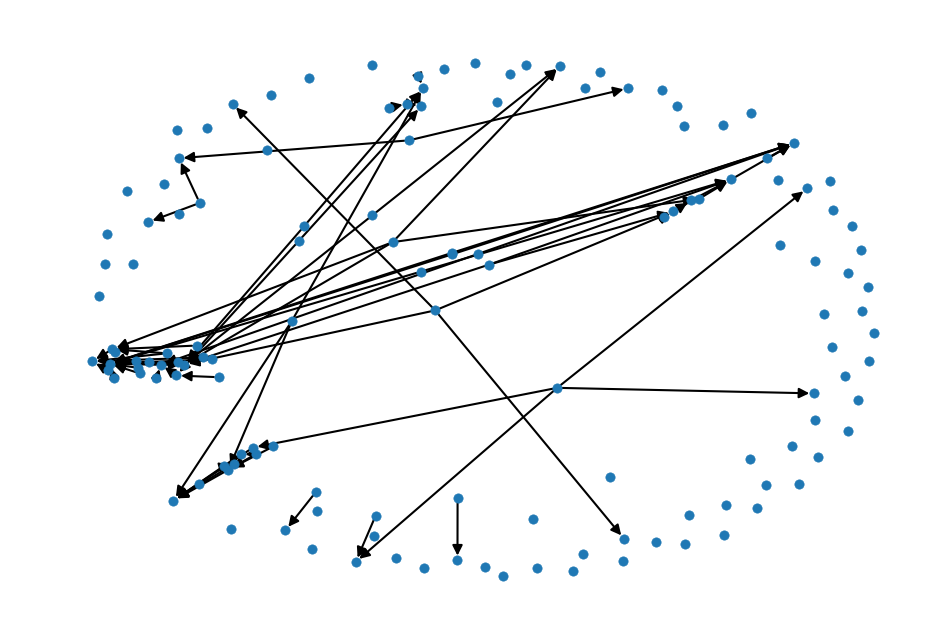

In [21]:
np.random.seed(0)
nx.draw(graph, node_size=20)
plt.show()

In [22]:
# nx.write_gexf(graph, "../results/citation-network/network_v2.gexf")

In [23]:
indegrees = [{"doi": d, "indegree": graph.in_degree(d)} for d in dois]
indegrees_df = pd.DataFrame(indegrees)
indegrees_df.sort_values(by="indegree", inplace=True, ascending=False, ignore_index=True)

In [24]:
metadata_byindegree = pd.merge(indegrees_df, metadata)
metadata_byindegree

,doi,indegree,title,date_published,date_published_print,journal,publisher,citations,paper_type,n_authors,manual_class,scopus_class
0,10.1101/2020.03.27.20043752,12,Forecasting COVID-19 impact on hospital bed-da...,2020-03-31 00:06:12+00:00,NaN,medRxiv,Cold Spring Harbor Laboratory,120.0,posted-content,2.0,NaN,Preprint
1,10.1016/j.chaos.2020.109829,7,"Predicting turning point, duration and attack ...",2020-04-20 07:55:25+00:00,2020-6,"Chaos, Solitons & Fractals",Elsevier BV,80.0,journal-article,3.0,NaN,General Mathematics
2,10.1073/pnas.2006520117,6,The challenges of modeling and forecasting the...,2020-07-03 01:14:52+00:00,2020-7-21,Proceedings of the National Academy of Sciences,Proceedings of the National Academy of Sciences,191.0,journal-article,5.0,NaN,Multidisciplinary
3,10.1101/2020.03.21.20040303,5,Initial Simulation of SARS-CoV2 Spread and Int...,2020-03-23 16:25:12+00:00,NaN,medRxiv,Cold Spring Harbor Laboratory,40.0,posted-content,2.0,NaN,Preprint
4,10.1101/2020.05.15.20103655,4,Differential Effects of Intervention Timing on...,2020-05-20 20:06:11+00:00,NaN,medRxiv,Cold Spring Harbor Laboratory,77.0,posted-content,3.0,NaN,Preprint
...,...,...,...,...,...,...,...,...,...,...,...,...
132,10.1016/j.chaos.2020.110152,0,Data driven estimation of novel COVID-19 trans...,2020-07-25 10:48:57+00:00,2020-11,"Chaos, Solitons & Fractals",Elsevier BV,3.0,journal-article,2.0,NaN,General Mathematics
133,10.1016/j.chaos.2020.110512,0,Data analysis of Covid-19 pandemic and short-t...,2020-11-28 16:17:53+00:00,2021-1,"Chaos, Solitons & Fractals",Elsevier BV,16.0,journal-article,1.0,NaN,General Mathematics
134,10.1093/jtm/taaa226,0,Curbing the COVID-19 pandemic with facility-ba...,2020-12-01 12:14:49+00:00,2021-2-23,Journal of Travel Medicine,Oxford University Press (OUP),12.0,journal-article,10.0,NaN,"Public Health, Environmental and Occupational ..."
135,10.1371/journal.pcbi.1009149,0,Covasim: An agent-based model of COVID-19 dyna...,2021-07-26 17:40:13+00:00,NaN,PLOS Computational Biology,Public Library of Science (PLoS),28.0,journal-article,26.0,NaN,"Ecology, Evolution, Behavior and Systematics"


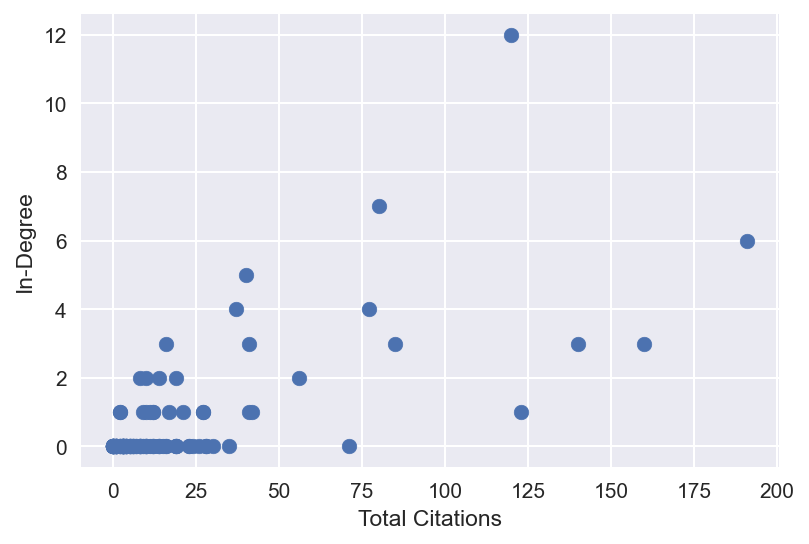

In [25]:
plt.scatter(metadata_byindegree.citations, metadata_byindegree.indegree)
plt.xlabel("Total Citations")
plt.ylabel("In-Degree")
plt.show()

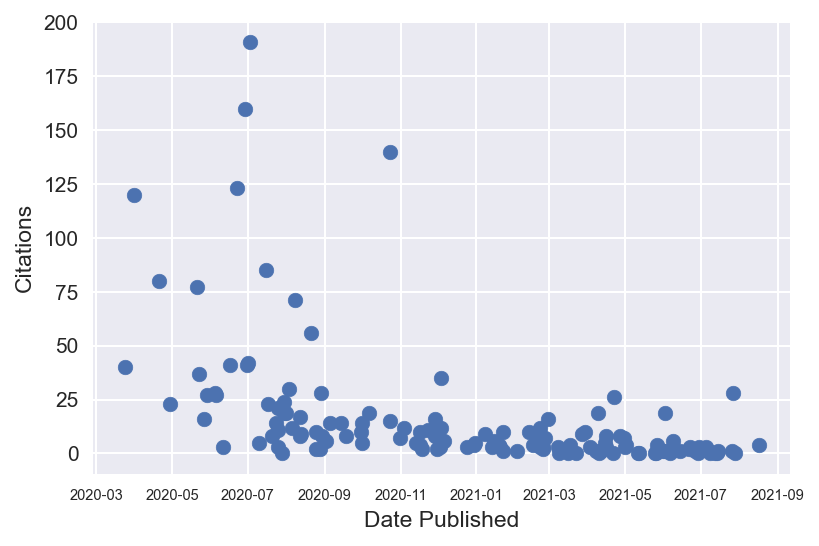

In [26]:
plt.scatter(metadata_byindegree.date_published, metadata_byindegree.citations)
plt.xlabel("Date Published")
plt.ylabel("Citations")
plt.xticks(fontsize=7)
plt.show()

In [27]:
def diff(a, b):
    return [x for x in a if x not in b]

In [28]:
outdegree_byjournal = {}
for j in metadata.journal:
    j_dois = metadata[metadata.journal == j].doi.tolist()
    n = max(1, len(j_dois))
    out_total = sum([x[1] for x in graph.out_degree(j_dois)])
    out_same = sum([x[1] for x in graph.subgraph(j_dois).out_degree(j_dois)])
    outdegree_byjournal[j] = {
        "journal": j,
        "outdegree_total": out_total,
        "outdegree_same": out_same,
        "outdegree_other": out_total - out_same,
        "outdegree_total_norm": out_total / n,
        "outdegree_same_norm": out_same / n,
        "outdegree_other_norm": (out_total - out_same) / n,
    }
outdegree_byjournal_l = list(outdegree_byjournal.values())
outdegree_byjournal_df = pd.DataFrame(outdegree_byjournal_l)
outdegree_byjournal_df.sort_values(by=["outdegree_total", "outdegree_same", "outdegree_other"], ascending=False, ignore_index=True, inplace=True)
outdegree_byjournal_df

,journal,outdegree_total,outdegree_same,outdegree_other,outdegree_total_norm,outdegree_same_norm,outdegree_other_norm
0,"Chaos, Solitons & Fractals",14,12,2,0.636364,0.545455,0.090909
1,medRxiv,11,4,7,1.100000,0.400000,0.700000
2,Scientific Reports,10,2,8,0.714286,0.142857,0.571429
3,arXiv,6,0,6,0.857143,0.000000,0.857143
4,ISA Transactions,4,0,4,1.333333,0.000000,1.333333
5,PLOS ONE,3,1,2,0.214286,0.071429,0.142857
6,Infectious Disease Modelling,3,0,3,0.428571,0.000000,0.428571
7,Nonlinear Dynamics,2,1,1,0.333333,0.166667,0.166667
8,Computer Methods in Applied Mechanics and Engi...,2,0,2,2.000000,0.000000,2.000000
9,PLOS Computational Biology,2,0,2,1.000000,0.000000,1.000000


In [29]:
indegree_byjournal = {}
for j in metadata.journal:
    j_dois = metadata[metadata.journal == j].doi.tolist()
    n = max(1, len(j_dois))
    in_total = sum([x[1] for x in graph.in_degree(j_dois)])
    in_same = sum([x[1] for x in graph.subgraph(j_dois).in_degree(j_dois)])
    indegree_byjournal[j] = {
        "journal": j,
        "indegree_total": in_total,
        "indegree_same": in_same,
        "indegree_other": in_total - in_same,
        "indegree_total_norm": in_total / n,
        "indegree_same_norm": in_same / n,
        "indegree_other_norm": (in_total - in_same) / n,
    }
indegree_byjournal_l = list(indegree_byjournal.values())
indegree_byjournal_df = pd.DataFrame(indegree_byjournal_l)
indegree_byjournal_df.sort_values(by=["indegree_total", "indegree_same", "indegree_other"], ascending=False, ignore_index=True, inplace=True)
indegree_byjournal_df

,journal,indegree_total,indegree_same,indegree_other,indegree_total_norm,indegree_same_norm,indegree_other_norm
0,"Chaos, Solitons & Fractals",27,12,15,1.227273,0.545455,0.681818
1,medRxiv,26,4,22,2.600000,0.400000,2.200000
2,Proceedings of the National Academy of Sciences,6,0,6,2.000000,0.000000,2.000000
3,Nonlinear Dynamics,3,1,2,0.500000,0.166667,0.333333
4,Computational Mechanics,3,0,3,1.500000,0.000000,1.500000
5,Nature Medicine,3,0,3,3.000000,0.000000,3.000000
6,Scientific Reports,2,2,0,0.142857,0.142857,0.000000
7,PLOS ONE,2,1,1,0.142857,0.071429,0.071429
8,Health & Place,1,1,0,0.500000,0.500000,0.000000
9,Infectious Disease Modelling,1,0,1,0.142857,0.000000,0.142857
